In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/Users/dhrumilpatel/Documents/mind-speech-interface-ssvep")

In [3]:
from eeg_ai_layer.models.FBCCA import FBCCA
from eeg_ai_layer.models.KNN import KNN
from eeg_ai_layer.models.train import segment_data_from_trials
from eeg_ai_layer.models.utils import split_trials

In [4]:
from types import SimpleNamespace

args = SimpleNamespace(
    components=1,
    window_length=4,
    sample_rate=250,
    shift_length=1,
    no_zero=True,
    model_type='fbcca_knn',
    model_path='eeg_ai_layer/models/savedmodels/ivan_fbccaknn.model'
)

fbcca = FBCCA(args)
knn = KNN(args)

In [7]:
import pandas as pd

data = pd.read_csv("eeg_ai_layer/data/new_ui/ivan/284_2022_448194.csv")

In [8]:
data

,time,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,Color Code,Frequency
0,2022-10-11 18:11:17.508270,750000.062500,750000.062500,750000.062500,750000.062500,750000.062500,-750000.125000,750000.062500,750000.062500,0.0,0.0
1,2022-10-11 18:11:17.510758,750000.062500,750000.062500,750000.062500,750000.062500,750000.062500,-750000.125000,750000.062500,750000.062500,NaN,NaN
2,2022-10-11 18:11:17.515774,256387.843750,750000.062500,679771.625000,750000.062500,750000.062500,-750000.125000,750000.062500,750000.062500,NaN,NaN
3,2022-10-11 18:11:17.527636,-311828.218750,750000.062500,673430.437500,724768.937500,750000.062500,-688414.187500,750000.062500,750000.062500,NaN,NaN
4,2022-10-11 18:11:17.527679,-302257.750000,750000.062500,683498.500000,750000.062500,750000.062500,-214743.859375,750000.062500,750000.062500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
218320,2022-10-11 18:25:48.938380,86164.460938,94956.648438,110146.179688,97438.234375,76597.109375,76554.546875,49041.875000,74353.531250,NaN,NaN
218321,2022-10-11 18:25:48.965267,86160.523438,94952.359375,110132.593750,97422.851562,76587.359375,75333.070312,49036.511719,74334.039062,NaN,NaN
218322,2022-10-11 18:25:48.965298,86173.312500,94967.468750,110165.851562,97441.539062,76600.859375,75454.757812,49049.296875,74371.234375,NaN,NaN
218323,2022-10-11 18:25:48.990942,86174.296875,94969.078125,110178.726562,97454.773438,76609.085938,76774.218750,49052.515625,74392.867188,NaN,NaN


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
data.drop(columns=['time', 'Color Code'], inplace=True)

# offset 1 for Timestep
if all(data.iloc[0, 1:].values == 0):
    data.at[1, 'Frequency'] = data.loc[0, 'Frequency']
    data = data[1:]
    data.index = np.arange(data.shape[0])

trials = split_trials(data)
X, y = segment_data_from_trials(trials=trials, window_length=args.window_length,
                                                    shift_length=args.shift_length,
                                                    sample_rate=args.sample_rate, no_zero=args.no_zero)
X = np.array(X)

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    knn = KNN(args)
#     correlations = knn.prepare(sus)
#     predictions = knn.predict(correlations)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.show()

(64, 1000, 8)


KeyboardInterrupt: 

In [11]:
trial_freq = [(trial, trial.iloc[0]['Frequency']) for trial in trials]
non_zero_trials = [t[0] for t in trial_freq if t[1] != 0]

In [12]:
non_zero_trials

[                            time           CH1           CH2            CH3  \
 6520  2022-10-11 18:11:43.526673  89283.421875  97884.820312  128854.148438   
 6521  2022-10-11 18:11:43.526752  89315.250000  97915.218750  128850.929688   
 6522  2022-10-11 18:11:43.536133  89296.921875  97895.460938  128774.843750   
 6523  2022-10-11 18:11:43.539200  89244.171875  97843.421875  128732.109375   
 6524  2022-10-11 18:11:43.539265  89234.601562  97835.468750  128761.968750   
 ...                          ...           ...           ...            ...   
 7751  2022-10-11 18:11:48.431780  89271.531250  97882.046875  128165.804688   
 7752  2022-10-11 18:11:48.433531  89292.453125  97904.757812  128219.445312   
 7753  2022-10-11 18:11:48.461150  89295.937500  97909.140625  128254.585938   
 7754  2022-10-11 18:11:48.486314  89284.765625  97896.351562  128215.867188   
 7755  2022-10-11 18:11:48.511171  89272.515625  97882.851562  128177.875000   
 
                 CH4           CH5    

<Figure size 5000x3000 with 0 Axes>

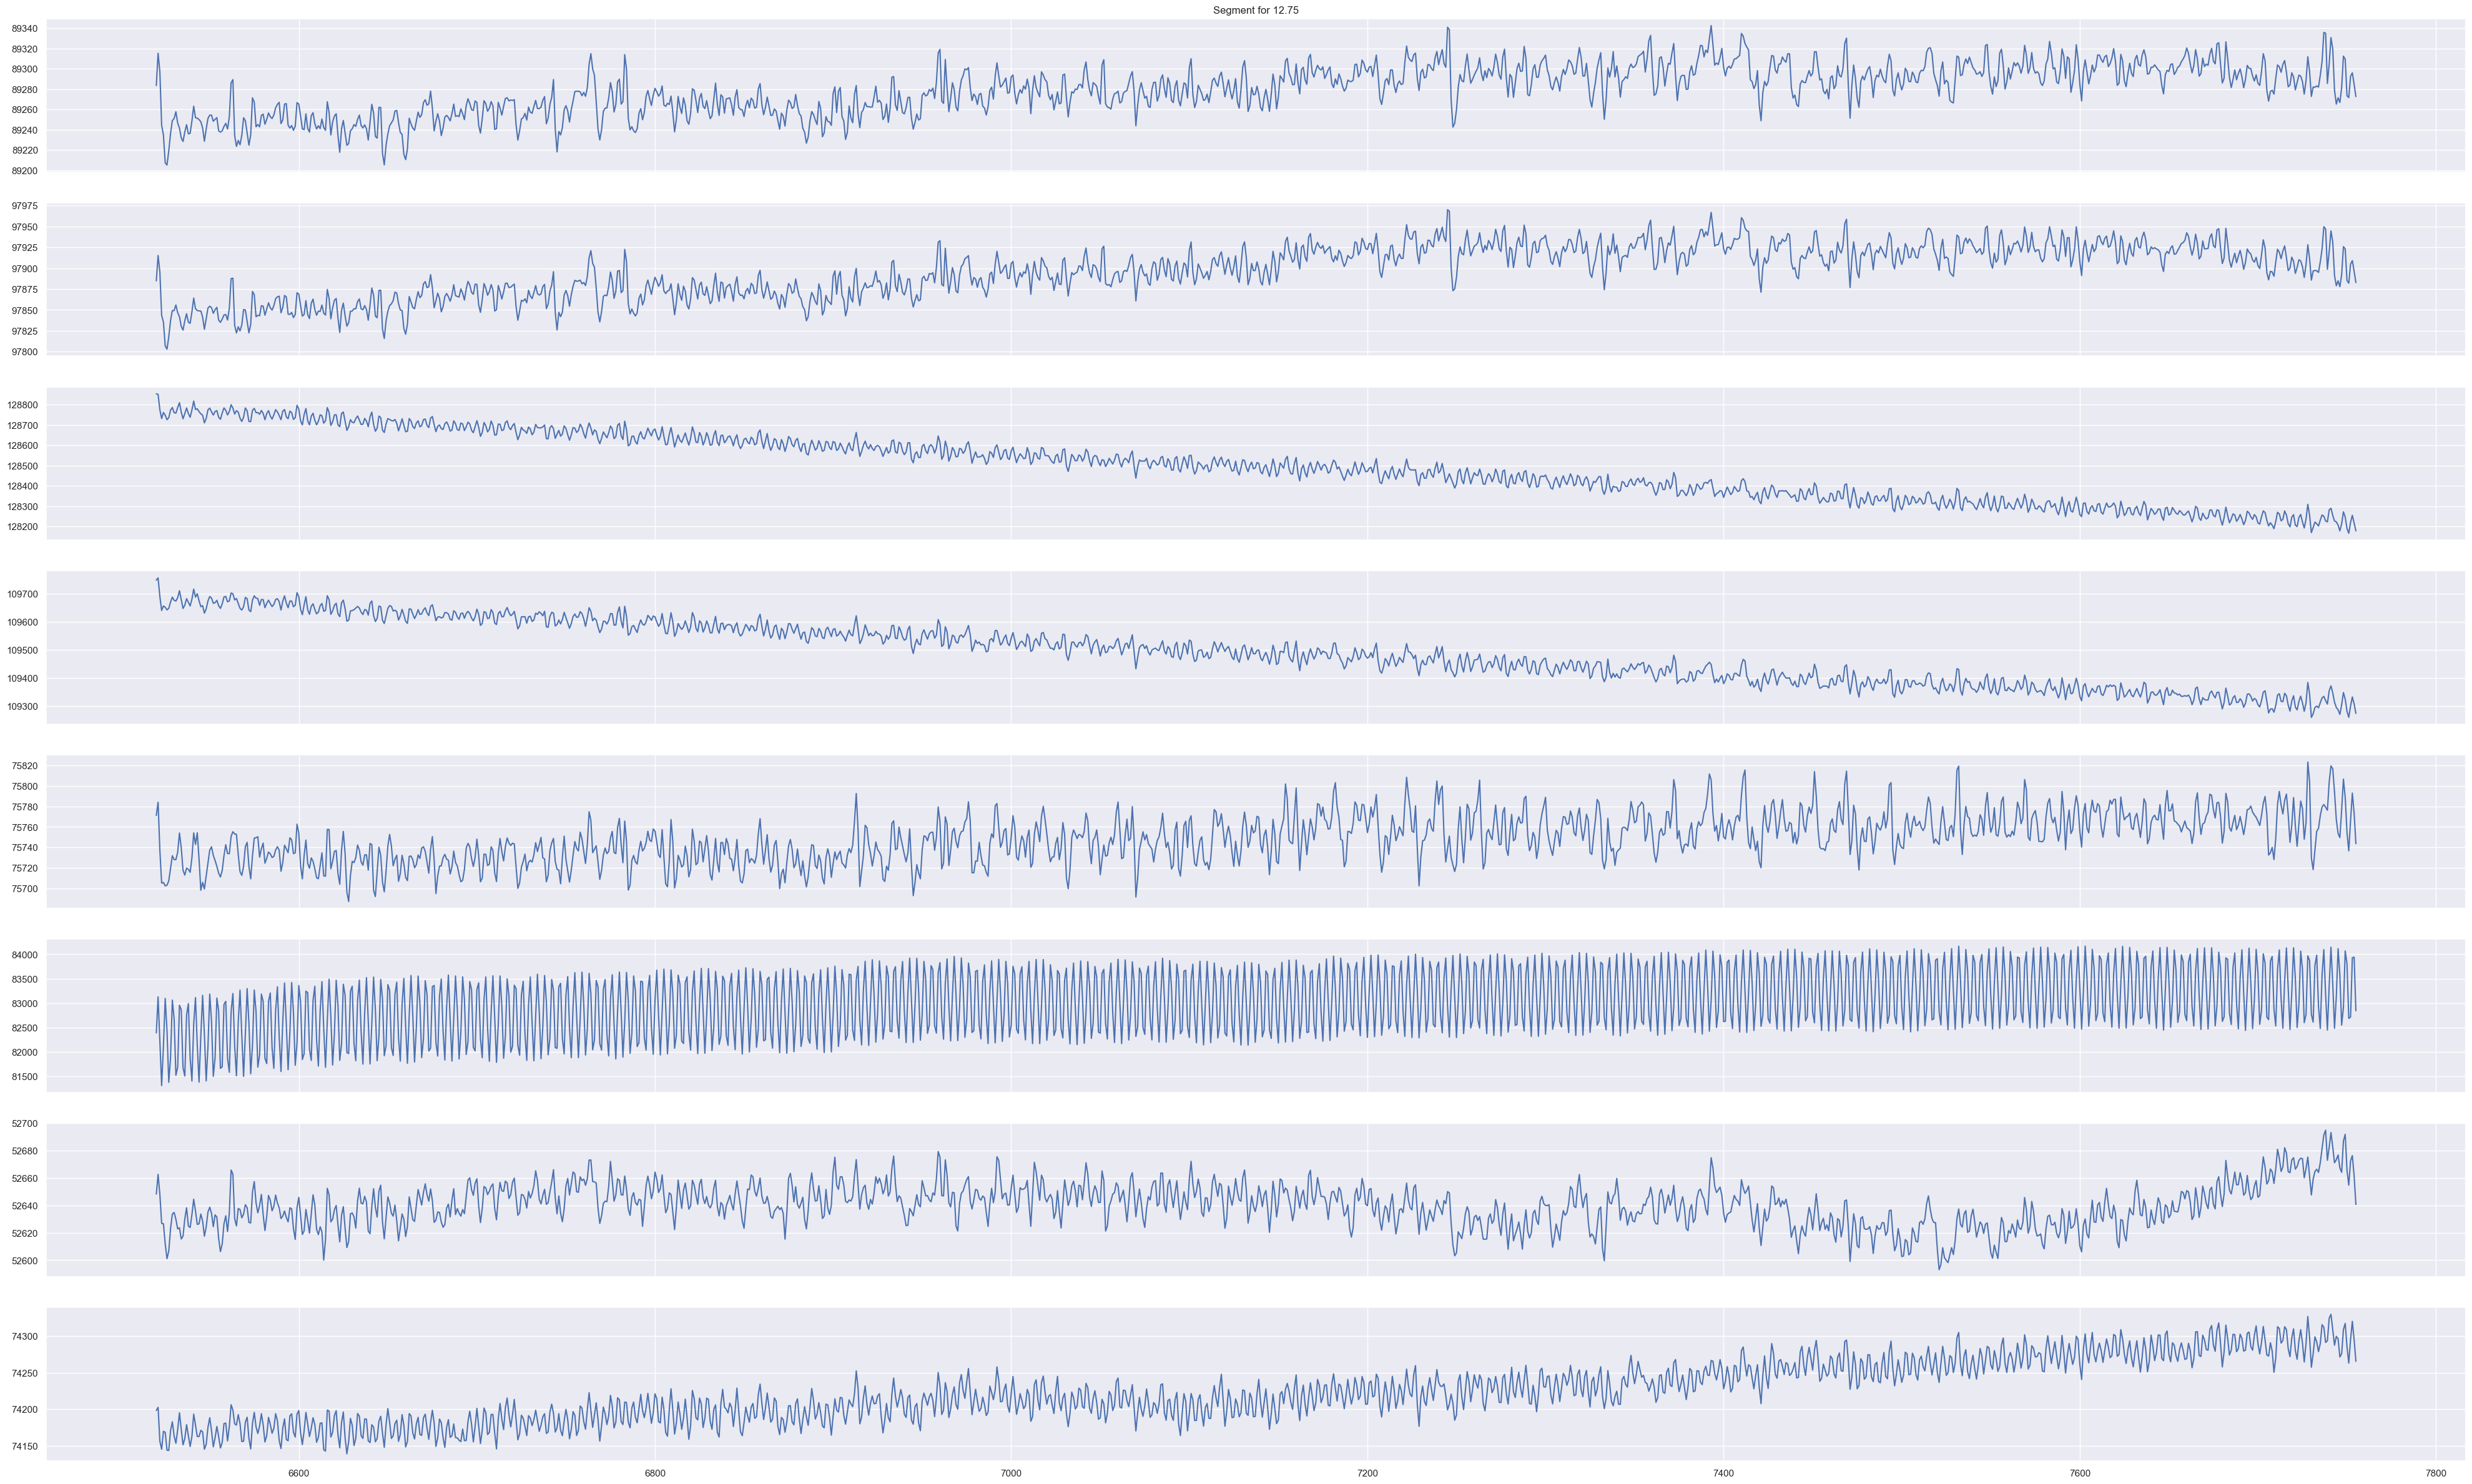

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

sns.set()

plt.figure(figsize=(50, 30))
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(50, 30))
for idx, ax in enumerate(axes):
#     ax.plot(data.loc[1250:, "8"], data.loc[10:, str(idx)])
    ax.plot(non_zero_trials[0].loc[:, f"CH{idx + 1}"])
axes[0].set_title(f"Segment for {non_zero_trials[0].iloc[0]['Frequency']}")
plt.show()

In [ ]:
cool_trial = non_zero_trials[0]


fbcca.predict()